In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch_geometric.datasets import KarateClub
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx, dropout_adj
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps
from tqdm.notebook import tqdm, trange

## Links:

* http://cse.msu.edu/~mayao4/tutorials/aaai2021/ (3 hrs video lecture on robustness - Claire)
* https://www.youtube.com/watch?v=pH1Zz6c1Q7A&t=3s (Henry AI labs)
* https://www.youtube.com/watch?v=2KRAOZIULzw (WelcomeAIOverlords)
* https://blog.zakjost.com/post/gcn_citeseer/
* https://www.youtube.com/watch?v=wJQQFUcHO5U (relational GNN)
* https://docs.dgl.ai/en/0.4.x/tutorials/basics/3_pagerank.html (some graph-related knowledge here)
* https://networkx.org/documentation/stable/tutorial.html (networkx tutorial)


* https://docs.google.com/document/d/1tpXn-FKFi8V3CskKwWZYEzqae8Xa2iYEwH8gpeXDVsc/edit (Claire's Google Docs)
* https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=H_VTFHd0uFz6 (torch geometric tutorial 1)

## Things to consider doing
* Write a function that computes accuracy by centrality score 
* Write a function to compute 2-hop degree
* Delete/add edges for link prediction task 
* Effect of nonlinearity

## Utility functions

In [2]:
#h: (batch_size, feature_num), color = data.y (labels), shape:(batch_size,)
def visualize_graph(G, color, size=300, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2", node_size = size)
    plt.show()
    
def visualize_tsne(out, color, size=30, epoch=None, loss = None):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()
    
def visualize_pca(out, color, size=30, epoch=None, loss=None):
    h = PCA(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(h[:, 0], h[:, 1], s=size, c=color, cmap="Set2")    
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()
    
def delete_undirected_edges(edge_index, p):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    edges = random.sample(edges, round(n*(1-p)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1],x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()

def add_undirected_edges(edge_index, edge_num, node_total = 2708):
    edges = torch.clone(edge_index).t().numpy() #clone edges to prevent modifying original edges
    edges = set(map(frozenset, edges)) #for undirected graphs, remove duplicate edges such as (1,2) and (2,1)
    n = len(edges)
    while len(edges) - n < edge_num:
        edges.add(frozenset(random.sample(range(node_total), 2)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1],x[0]], edges)) #for undirected graphs, add edges in the other direction
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()

def dataset_print(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')
    
def data_print(data):
    print(data)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

#get number of correct predictions for each node degree
def correct_num_by_degree(nxgraph, model, model_inputs, labels):
    node_degree = nxgraph.degree
    _, predicted = test(model, model_inputs, labels)
    correct_num = collections.defaultdict(int)
    total_num = collections.defaultdict(int)
    
    for node, degree in nxgraph.degree:
        total_num[degree] += 1
        if predicted[node] == labels[node]:
            correct_num[degree] += 1
    return correct_num, total_num

def timethis(func):
    @wraps(func) #preserving function metadata
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Time to run function '{}': {:.2f} seconds".format(func.__name__, end-start)) 
        return result
    return wrapper
    
# nx.draw_shell(G, with_labels=True, font_weight='bold')

## Training functions

In [18]:
mask = collections.namedtuple('mask', ('train', 'test')) #tuple to store train mask, test mask

def train_one_epoch(model, criterion, optimizer, x, y, train_mask = None): #x is a dictionary
    model.train()
    out = model(**x)
    loss = criterion(out, y) if train_mask is None else criterion(out[train_mask], y[train_mask])
    _, predicted = torch.max(out.detach(),1)
    
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        if train_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item()/length
        else:
            length = len(y[train_mask])
            accuracy = (predicted[train_mask] == y[train_mask].detach()).sum().item()/length
    
    return out, loss.item(), accuracy

def test(model, x, y, test_mask = None): #x is a dictionary
    model.eval()
    with torch.no_grad():
        out = model(**x)
        _, predicted = torch.max(out, 1)
        if test_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item()/length
        else:
            length = len(y[test_mask])
            accuracy = (predicted[test_mask] == y[test_mask]).sum().item()/length
    return accuracy, predicted
    
def plot_acc(train_acc, test_acc=None):
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    if test_acc is not None:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.plot(np.arange(len(test_acc)), test_acc, color='blue')
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
    else: 
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.legend(['train accuracy'], loc='upper right')
    plt.title('Accuracy plot')
    plt.tight_layout()
    plt.show() #show train_acc and test_acc together
    
def plot_loss(loss):
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.plot(np.arange(len(loss)), loss, color='black')
    plt.title('Loss plot')
    plt.tight_layout()
    plt.show()

@timethis
def train(epochs, model, criterion, optimizer, x, y, m = mask(None, None), 
          plotting = True, scatter_size = 30, plotting_freq = 5, dim_reduction = 'pca'):
    dim_reduction_dict = {'pca': visualize_pca, 'tsne': visualize_tsne}
    train_acc_list = []
    test_acc_list = []
    loss_list = []
    for epoch in tqdm(range(epochs)):
        out, loss, train_acc = train_one_epoch(model, criterion, optimizer, x, y, m.train)
        model.eval()
        test_acc, _ = test(model, x, y, m.test)
        train_acc_list.append(train_acc)
        loss_list.append(loss)
        test_acc_list.append(test_acc)
        if plotting:
            if epoch % plotting_freq == 0:
                clear_output(wait=True)
                dim_reduction_dict[dim_reduction](out, color=y, size = scatter_size, epoch=epoch, loss = loss)
    if plotting:
        if m == mask(None, None):
            plot_acc(train_acc_list)
        else:
            plot_acc(train_acc_list, test_acc_list)
        plot_loss(loss_list)
    return train_acc_list, test_acc_list, loss_list

## Karate dataset

In [19]:
from torch_geometric.datasets import KarateClub

karateset = KarateClub()
dataset_print(karateset)
print()
print('Information about the graph in the dataset:')
print()
karate=karateset[0] #a single graph
data_print(karate)
G = to_networkx(karate, to_undirected=True)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Information about the graph in the dataset:

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


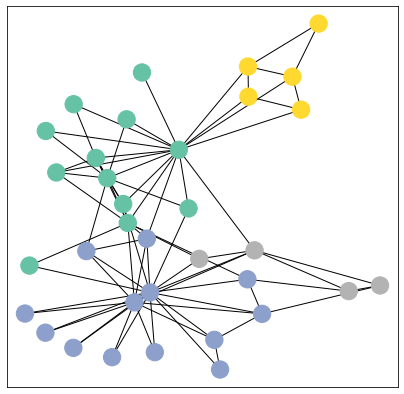

In [20]:
visualize_graph(G, color=karate.y) #with node labels 

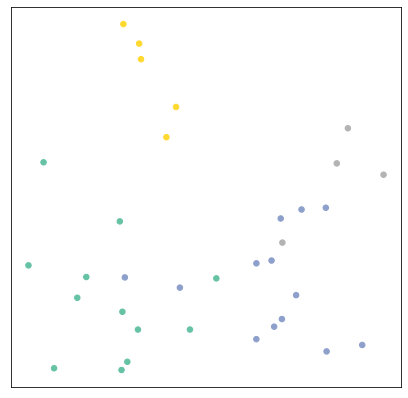

In [21]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.linear = Linear(2, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh() #shape: (34,2)
        out = self.linear(h) #shape: (34,4)
        return out

model = GCN(karateset.num_features, karateset.num_classes)
outt = model(karate.x, karate.edge_index)
visualize_pca(outt, color=karate.y)



In [23]:
model = GCN(karateset.num_features, karateset.num_classes)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
train_acc_list, test_acc_list, loss_list = train(1000, model, criterion, optimizer,
                                                 x={'x': karate.x, 'edge_index': karate.edge_index}, y = karate.y, plotting = False)


  0%|          | 0/1000 [00:00<?, ?it/s]

Time to run function 'train': 2.62 seconds


## Cora dataset

In [9]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

coraset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [10]:
dataset_print(coraset)
cora = coraset[0]
print()
data_print(cora)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


KeyboardInterrupt: 

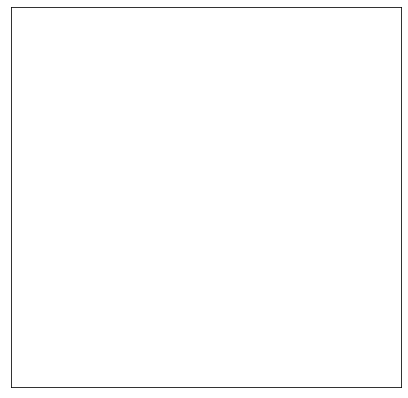

In [11]:
G = to_networkx(cora, to_undirected=True)
visualize_graph(G, color=cora.y, size=10) #visualize the Cora graph

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        out = self.lin2(x)
        return out

linear_model = MLP(hidden_channels=16, num_features = coraset.num_features, num_classes=coraset.num_classes)
visualize_tsne(linear_model(cora.x), color=cora.y, size=30) #TSNE visualization of model output before training

In [ ]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list = train(300, linear_model, criterion, optimizer, 
                                                 x={'x': cora.x}, y=cora.y, m=mask(cora.train_mask, cora.test_mask),
                                                scatter_size=30)

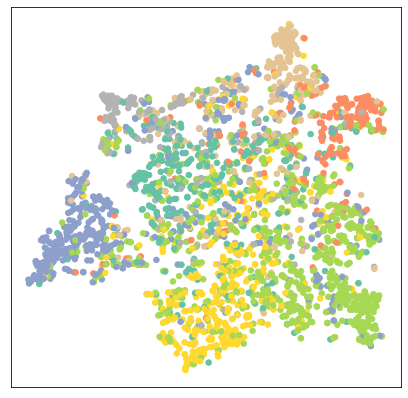

In [13]:
visualize_tsne(linear_model(cora.x), color=cora.y, size=30) #TSNE visualization of model output after training 

In [12]:
class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(GCN2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        h = F.dropout(x, p=0.5, training=self.training)
        out = self.conv2(h, edge_index)
        return out

GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
# GCN2_model(cora.x, cora.edge_index).shape
# visualize_tsne(GCN2_model(cora.x, cora.edge_index), color=cora.y, size=30)

In [147]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
train_acc_list, test_acc_list, loss_list = train(400, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y,
                                                scatter_size = 30, dim_reduction='tsne')

KeyboardInterrupt: 

In [ ]:
visualize_tsne(GCN2_model(cora.x, cora.edge_index), color=cora.y, size=30)

In [ ]:
visualize_tsne(GCN2_model(cora.x, cora.edge_index), color=cora.y, size=30)

## Deleting edges

Text(0.5, 0, 'Percentage of edges deleted')

Text(0, 0.5, 'Test accuracy')

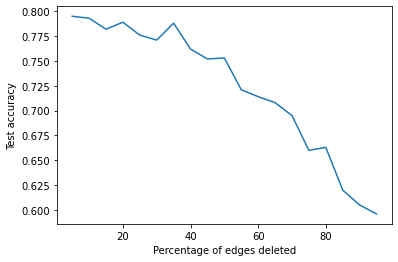

In [14]:
p_list = np.arange(0.05, 1, 0.05)
num_epochs = 200
acc_list = []
for p in p_list:
    GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
    edges = delete_undirected_edges(cora.edge_index, p)
    _, test_acc_list, _ = train(num_epochs, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': edges}, y = cora.y,
                                                plotting = False)
    acc_list.append(test_acc_list[-1])


clear_output(wait=True)
plt.plot(p_list*100, acc_list)
plt.xlabel("Percentage of edges deleted")
plt.ylabel("Test accuracy")

Below, the same experiment is run but we use the $\texttt{dropout_adj}$ function in $\texttt{torch_geometric.utils}$:

In [144]:
p_list = np.arange(0.05, 1, 0.05)
num_epochs = 200
acc_list = []
for p in p_list:
    GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
    edges = dropout_adj(cora.edge_index, force_undirected=True, p=p)[0] #this is the only change 
    _, test_acc_list, _ = train(num_epochs, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': edges}, y = cora.y,
                                                plotting = False)
    acc_list.append(test_acc_list[-1])

clear_output(wait=True)
plt.plot(p_list*100, acc_list)
plt.xlabel("Dropout probability")
plt.ylabel("Test accuracy")

NameError: name 'GCN2' is not defined

## Adding random edges

In [52]:
n_list = range(0, 20000, 1000)
acc_list = []
for n in n_list:
    GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
    edges = add_undirected_edges(cora.edge_index, n)
    _, test_acc_list, _ = train(num_epochs, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': edges}, y = cora.y,
                                                plotting = False)
    acc_list.append(test_acc_list[-1])
clear_output(wait=True)
plt.plot(n_list, acc_list)
plt.xlabel("Number of false edges added")
plt.ylabel("Test accuracy")

NameError: name 'GCN2' is not defined

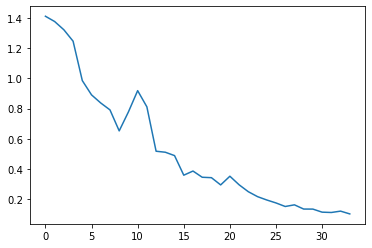

In [129]:
class DeepGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, num_GCN):
        super(DeepGCN, self).__init__()
        torch.manual_seed(12345)
        self.first_conv = GCNConv(num_features, hidden_channels)
        self.GCNs = torch.nn.ModuleList([GCNConv(hidden_channels, hidden_channels) for i in range(num_GCN)])
        self.last_conv = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index, lst):
        x = self.first_conv(x, edge_index)
#         x = F.tanh(x)
        for l in self.GCNs:
            x = l(x, edge_index)
#             x = F.tanh(x)
            lst.append(x.detach().cpu().numpy())
        out = self.last_conv(x, edge_index)
        return out
    
deep_GCN_model = DeepGCN(16, coraset.num_features, coraset.num_classes, 35)
lst = []
_ = deep_GCN_model(cora.x, cora.edge_index, lst)
diff = []
for i in range(len(lst)-1):
    diff.append(np.linalg.norm(lst[i+1]-lst[i]))
plt.plot(list(range(len(diff))), diff)

In [44]:
diff = []
for i in range(len(lst)-1):
    diff.append(np.linalg.norm(lst[i+1]-lst[i]))

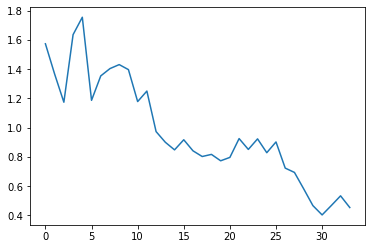

In [143]:
class DeepGAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, num_GAT):
        super(DeepGAT, self).__init__()
        self.first = GATConv(num_features, hidden_channels, heads=1)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.GATs = torch.nn.ModuleList([GATConv(hidden_channels, hidden_channels, heads=1) for i in range(num_GAT)])
        self.last = GATConv(hidden_channels, num_classes, heads=1)

    def forward(self, x, edge_index, lst):
        x = self.first(x, edge_index)
        x = F.tanh(x)
        for l in self.GATs:
            x = l(x, edge_index)
            x = F.tanh(x)
            lst.append(x.detach().cpu().numpy())
        out = self.last(x, edge_index)
        return out
    
deep_GAT_model = DeepGAT(16, coraset.num_features, coraset.num_classes, 35)
lst = []
_ = deep_GAT_model(cora.x, cora.edge_index, lst)
diff = []
for i in range(len(lst)-1):
    diff.append(np.linalg.norm(lst[i+1]-lst[i]))
plt.plot(list(range(len(diff))), diff)

GNN notes:

* Should compare with baseline models that ignore graph structure (linear regression, random forest)
* T-SNE can reduce the dimensions of feature vectors so you can plot in 2-D
* Message passing: a node in a graph can send or receive messages via its connections. Nodes when receiving messages can update itself or understand its environment
* Label smoothing vs feature smoothing: GCN also propagates features


* For any node, take all the feature vectors of its neighbors, take average so that node can be represented as the average of its neighbors. Then, pass this vector into a dense NN. The output of this dense layer is the new vector representation of the node (can be lower in dimension). 
* This process has to be done for every node in the graph. A single GCN layer consists of one operation like this for each node
* For the second GCN layer, the input is the updated vector from the first layer
* Only difference with regular neural network: nodes just have to aggregate its neighbors first before passing through dense NN
* Example: Classify each tweet. Each tweet is connected to another if they have the same IP address or the same account. The content of the tweet is the node attributes
* Logistic regression does not take advantage of the graph structure, whereas label propagation does not take advantage of the contents of the tweets
* How far signals travel depend on the number of GCN layers. If long-range signal travelling is important, you need more GCN layers
* What if your edges are of different types? Relational GCN. Nodes might also be of different types


* Note that for regular GCN: There's only one weight matrix for a single layer
* Equation below: $l$ is for layer, $i$ is node $i$, $c_{ij}$: normalization constant (if you use averaging, then it's like the degree of node $i$), $h$ is the embedding. Notice: there is no $i$ or $j$ on $W^l$

$$h_i^{l+1} = \sigma\left(\Sigma_{j\in N_i}\frac{1}{c_{ij}}h_j^lW^l\right) $$

* Knowledge graphs: source node, relation type, destination node. An example: you have two different node types (people, tweets), and also different relation types (follows, retweets)

* Relational GCNs solve this by having different projection matrices for each type of triples. "Person blocks person" has one weight matrix; "person follows person" has another weight matrix
* Equation below: $r$ represents the relation type. Note that $r$ is on the neighborhood and on the weight matrix. Each relation type has its own relation matrix. $W_0$ is giving attention to self-connections. You don't want to give equal treatments to a node's own representation

$$h_i^{l+1} = \sigma\left(W_0^lh_i^l + \Sigma_{r\in R}\Sigma_{j \in N_i^r} \frac{1}{c_{ir}} W_r^lh_j^l\right) $$

* The projection matrices above will put relation types to the same space so we can sum them together. Hopefully, "person A blocks person B" might cancel out "person A follows person B"

* Problem: what if there are too many relation types? Basis decomposition: you need to specify the number of unique W's you want to have for the layer. Example: If you have 100 relation types, each relation type will learn 2 coefficients

$$W_r^l = \Sigma_{b=1}^B a_{rb}^lV_b^l $$

* Example: For relations "blocks" and "follows", maybe it doesn't make sense to have two separate weight matrices for both since they are similar. Just learn coefficient

* Can also use block diagonalization ??

* Note that GCN uses edge information: $\texttt{def forward(self, x, edge_index):}$

* Even without training, GCN tends to map nodes with similar connections to the same output

* Read-out layer ??

## drafts

In [26]:
from torch_geometric.utils import dropout_adj
dropout_adj(cora.edge_index, force_undirected=True)[0]

torch.Size([2, 5378])

In [31]:
G = to_networkx(cora, to_undirected=True)

<Figure size 504x504 with 0 Axes>

([], <a list of 0 Text major ticklabel objects>)

([], <a list of 0 Text major ticklabel objects>)

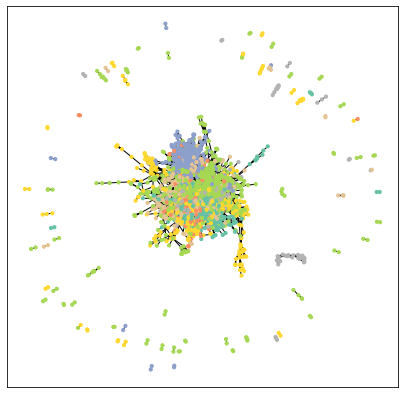

In [50]:
plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=cora.y, cmap="Set2", node_size = 10)
plt.show()

In [36]:
cora.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [39]:
(2707, 2707) in G.edges

False

In [77]:
float()

0.0

In [93]:
#assume nodes are listed from 0 to max_node
def correct_num_by_degree(nxgraph, model, model_inputs, labels):
    node_degree = nxgraph.degree
    _, predicted = test(model, model_inputs, labels)
    correct_num = collections.defaultdict(int)
    total_num = collections.defaultdict(int)
    
    for node, degree in nxgraph.degree:
        total_num[degree] += 1
        if predicted[node] == labels[node]:
            correct_num[degree] += 1
    return correct_num, total_num

GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
_, _, _ = train(num_epochs, GCN2_model, criterion, optimizer, 
                            m=mask(cora.train_mask, cora.test_mask), 
                            x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y,
                            plotting = False)
G = to_networkx(cora, to_undirected=True)
dict1, dict2 = correct_num_by_degree(G, GCN2_model, {'x': cora.x, 'edge_index': cora.edge_index}, cora.y)

Time to run function 'train': 3.64 seconds


In [94]:
dict1

{3: 0.840867992766727,
 5: 0.8647686832740213,
 1: 0.7443298969072165,
 4: 0.8483290488431876,
 2: 0.8164665523156089,
 7: 0.8658536585365854,
 6: 0.7938931297709924,
 9: 0.8,
 8: 0.8421052631578947,
 12: 0.8888888888888888,
 10: 0.8461538461538461,
 36: 1.0,
 11: 0.7857142857142857,
 21: 0.6666666666666666,
 32: 1.0,
 19: 0.8,
 13: 1.0,
 78: 1.0,
 17: 0.875,
 14: 1.0,
 16: 0.7142857142857143,
 18: 0.6666666666666666,
 15: 1.0,
 33: 1.0,
 29: 0,
 34: 1.0,
 23: 1.0,
 30: 0.5,
 26: 1.0,
 168: 1.0,
 22: 0,
 42: 1.0,
 74: 1.0,
 44: 1.0,
 31: 1.0,
 65: 1.0,
 40: 1.0}

In [95]:
dict2

defaultdict(int,
            {3: 553,
             5: 281,
             1: 485,
             4: 389,
             2: 583,
             7: 82,
             6: 131,
             9: 25,
             8: 57,
             12: 18,
             10: 26,
             36: 1,
             11: 14,
             21: 3,
             32: 2,
             19: 5,
             13: 5,
             78: 1,
             17: 8,
             14: 6,
             16: 7,
             18: 3,
             15: 6,
             33: 1,
             29: 1,
             34: 1,
             23: 3,
             30: 2,
             26: 1,
             168: 1,
             22: 1,
             42: 1,
             74: 1,
             44: 1,
             31: 1,
             65: 1,
             40: 1})

In [87]:
help(dict.fromkeys)

Help on built-in function fromkeys:

fromkeys(iterable, value=None, /) method of builtins.type instance
    Create a new dictionary with keys from iterable and values set to value.



In [89]:
dict.fromkeys(mydict.keys(), 0)

{3: 0,
 5: 0,
 1: 0,
 4: 0,
 2: 0,
 7: 0,
 6: 0,
 9: 0,
 8: 0,
 12: 0,
 10: 0,
 36: 0,
 11: 0,
 21: 0,
 32: 0,
 19: 0,
 13: 0,
 78: 0,
 17: 0,
 14: 0,
 16: 0,
 18: 0,
 15: 0,
 33: 0,
 34: 0,
 23: 0,
 26: 0,
 168: 0,
 30: 0,
 42: 0,
 74: 0,
 44: 0,
 31: 0,
 65: 0,
 40: 0}

In [86]:
mydict

defaultdict(int,
            {3: 465,
             5: 243,
             1: 361,
             4: 330,
             2: 476,
             7: 71,
             6: 104,
             9: 20,
             8: 48,
             12: 16,
             10: 22,
             36: 1,
             11: 11,
             21: 2,
             32: 2,
             19: 4,
             13: 5,
             78: 1,
             17: 7,
             14: 6,
             16: 5,
             18: 2,
             15: 6,
             33: 1,
             34: 1,
             23: 3,
             26: 1,
             168: 1,
             30: 1,
             42: 1,
             74: 1,
             44: 1,
             31: 1,
             65: 1,
             40: 1})

In [63]:
for n, d in G.degree:
    print(n, d)

0 3
1 3
2 5
3 1
4 5
5 3
6 4
7 1
8 3
9 2
10 2
11 2
12 4
13 2
14 5
15 4
16 4
17 5
18 5
19 1
20 5
21 2
22 5
23 1
24 7
25 4
26 5
27 4
28 1
29 2
30 6
31 1
32 4
33 9
34 1
35 3
36 8
37 3
38 4
39 7
40 3
41 4
42 2
43 6
44 3
45 6
46 2
47 2
48 9
49 2
50 1
51 6
52 5
53 3
54 2
55 12
56 4
57 1
58 1
59 10
60 3
61 5
62 1
63 1
64 3
65 10
66 1
67 3
68 3
69 7
70 2
71 3
72 2
73 12
74 9
75 6
76 3
77 2
78 3
79 2
80 3
81 4
82 2
83 2
84 5
85 3
86 4
87 3
88 36
89 10
90 4
91 6
92 2
93 4
94 11
95 21
96 1
97 2
98 1
99 6
100 2
101 3
102 8
103 6
104 4
105 4
106 1
107 4
108 3
109 32
110 5
111 6
112 4
113 3
114 3
115 1
116 2
117 2
118 19
119 6
120 5
121 7
122 4
123 4
124 5
125 2
126 6
127 1
128 4
129 2
130 3
131 2
132 5
133 9
134 1
135 3
136 1
137 4
138 3
139 8
140 2
141 3
142 5
143 3
144 4
145 6
146 5
147 2
148 5
149 4
150 3
151 4
152 4
153 6
154 12
155 7
156 6
157 4
158 4
159 2
160 7
161 2
162 5
163 1
164 2
165 4
166 2
167 4
168 3
169 2
170 2
171 3
172 5
173 4
174 4
175 7
176 3
177 4
178 1
179 3
180 10
181 4
182 2


1823 3
1824 8
1825 4
1826 8
1827 4
1828 4
1829 5
1830 4
1831 2
1832 1
1833 3
1834 5
1835 3
1836 2
1837 4
1838 4
1839 6
1840 3
1841 5
1842 10
1843 2
1844 3
1845 2
1846 5
1847 3
1848 7
1849 7
1850 4
1851 6
1852 2
1853 1
1854 1
1855 2
1856 5
1857 3
1858 2
1859 2
1860 1
1861 1
1862 4
1863 2
1864 4
1865 3
1866 2
1867 3
1868 4
1869 10
1870 4
1871 4
1872 1
1873 5
1874 6
1875 3
1876 2
1877 2
1878 3
1879 4
1880 4
1881 5
1882 5
1883 1
1884 6
1885 3
1886 2
1887 2
1888 3
1889 9
1890 2
1891 3
1892 3
1893 2
1894 14
1895 2
1896 4
1897 2
1898 4
1899 5
1900 2
1901 6
1902 10
1903 8
1904 3
1905 2
1906 5
1907 8
1908 7
1909 6
1910 2
1911 4
1912 10
1913 4
1914 31
1915 2
1916 3
1917 3
1918 2
1919 6
1920 6
1921 3
1922 2
1923 2
1924 3
1925 3
1926 7
1927 13
1928 5
1929 4
1930 2
1931 3
1932 3
1933 4
1934 2
1935 5
1936 5
1937 2
1938 1
1939 2
1940 4
1941 5
1942 3
1943 2
1944 6
1945 6
1946 4
1947 4
1948 3
1949 2
1950 15
1951 4
1952 10
1953 3
1954 9
1955 8
1956 4
1957 6
1958 7
1959 5
1960 4
1961 3
1962 3
1963 2
1964

In [49]:
max(dict(G.degree).items(), key=lambda x: x[1])

(1358, 168)

In [59]:
out = GCN2_model(cora.x, cora.edge_index)
_, predicted = torch.max(out, 1)
predicted

tensor([3, 4, 4,  ..., 1, 3, 3])

In [60]:
cora.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [41]:
nx.betweenness_centrality(G)

{0: 9.76615354875872e-07,
 1: 0.001080476705520546,
 2: 0.0040508162724597506,
 3: 0.0,
 4: 0.00055117615382112,
 5: 7.501561061887951e-06,
 6: 0.0006987223189870186,
 7: 0.0,
 8: 0.0026983944411181357,
 9: 0.0,
 10: 0.0006779390761298553,
 11: 0.0,
 12: 5.460644995004875e-07,
 13: 0.0008479377334516646,
 14: 0.0008971827115009842,
 15: 0.0,
 16: 2.477326635979589e-05,
 17: 0.0008845896023690468,
 18: 0.0002375253612377142,
 19: 0.0,
 20: 0.008091618406043576,
 21: 0.00012647571091374646,
 22: 0.002128739542046407,
 23: 0.0,
 24: 0.0030017034112762224,
 25: 0.003800963068675419,
 26: 3.185376247086177e-07,
 27: 0.0018611149547444234,
 28: 0.0,
 29: 0.00011421586971092507,
 30: 0.012475431153616516,
 31: 0.0,
 32: 0.0005654427497799613,
 33: 0.0024083376873795417,
 34: 0.0,
 35: 0.0,
 36: 0.0006291147270382673,
 37: 0.0018892500918654173,
 38: 9.3833525009444e-05,
 39: 0.01593718904636033,
 40: 0.0009380097471279671,
 41: 0.00040742184830701826,
 42: 3.821900087860202e-05,
 43: 0.006091

In [56]:
karate.y

tensor([0, 0, 0, 0, 2, 2, 2, 0, 3, 3, 2, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 0, 3, 1,
        1, 1, 3, 1, 1, 3, 3, 1, 3, 3])

In [58]:
data_print(karate)

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
